# NLP - IS Newsletters

In this script the following pipeline is implemented

* read in PDF files via *pdfplumber* --> dataframe format
* pre-preprocess text --> list of lists of strings format
* **invert** the single words in order to make text readable
* preprocess text --> gensim formats
* estimate LDA
* visualize via *pyLDAvis*


### Specify File Path

In [42]:
# specify file path

file_path = 'read_pdfs'

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Import Packages

Be sure to have the necessary packages installed locally. Be sure to download NLTK stopword list by uncommenting and running the following cell.

In [43]:
#import nltk; nltk.download('stopwords')

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
#Generic
import os
from os.path import join
import matplotlib.pyplot as plt
%matplotlib inline
import re
import numpy as np
import pandas as pd
from pprint import pprint

#NLTK Stopword List
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('arabic')

#Gensim (LDA-Modelling)
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#PDF-Reader
import pdfplumber

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### ToDo: Extend Stopword List

In [ ]:
'''
stop_words.extend(
'example1',
'example2'
)
'''

## Read PDFs

In [45]:
data_list = []
pages_list = []
file_list = []

for index, filename in enumerate(os.listdir(file_path)):
    if filename.endswith(".pdf"):
        with pdfplumber.open(join(file_path,filename)) as stream_pdf:
            pages_content = [i.extract_text() for i in stream_pdf.pages]
            number_pages = len(pages_content)
            data_list.extend(pages_content)
            pages_list.extend(i+1 for i in range(number_pages))
            file_list.extend([filename] * number_pages)
            
data_df = pd.DataFrame({'content': data_list,
                        'page': pages_list,
                        'file': file_list,
                        'date': np.nan})

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
data_df.head()

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,page,file,date
0,1 ـه1437/1/3 | لولأا ددعلا\nيملاعإ بتكم برقأ عجار لصاوتلل ـه 1437 مرحم 3 تبسلا لولأا ددعلا\nةعبا...,1,the-islamic-state-al-nabacc84_-newsletter-1.pdf,NaN
1,ـه1437/1/3 | لولأا ددعلا 2\n2,2,the-islamic-state-al-nabacc84_-newsletter-1.pdf,NaN
2,3 ـه1437/1/3 | لولأا ددعلا\nّ\n)تيركت( لامشو )يجيب( فارطأ يف ةضفارلا اهدبكتي ةريبك رئاسخ\n يف وج...,3,the-islamic-state-al-nabacc84_-newsletter-1.pdf,NaN
3,ـه1437/1/3 | لولأا ددعلا 4\nّ\n)ةروبصلا( ةيرق يف يريصنلا ماظنلا دونجو ينثولا عافدلا يدترم نوعجفي...,4,the-islamic-state-al-nabacc84_-newsletter-1.pdf,NaN
4,5 ـه1437/1/3 | لولأا ددعلا\nّ\nّ\nيلشماقلا ةنيدم يف ةينملأا زرافملا هققحت ديدج ينمأ قرخ\n ندملا ...,5,the-islamic-state-al-nabacc84_-newsletter-1.pdf,NaN


## Preprocessing - Remove Special Signs, Numbers, etc.

In [73]:
# Convert to list
data = data_df['content'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]
data = [re.sub('\n', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

# Remove Numbers
data = [re.sub("0", "", sent) for sent in data]
data = [re.sub("1", "", sent) for sent in data]
data = [re.sub("2", "", sent) for sent in data]
data = [re.sub("3", "", sent) for sent in data]
data = [re.sub("4", "", sent) for sent in data]
data = [re.sub("5", "", sent) for sent in data]
data = [re.sub("6", "", sent) for sent in data]
data = [re.sub("7", "", sent) for sent in data]
data = [re.sub("8", "", sent) for sent in data]
data = [re.sub("9", "", sent) for sent in data]

# block does not work
# Remove Brackets
''' 
data = [re.sub("\[", "", sent) for sent in data]
data = [re.sub("\]", "", sent) for sent in data]
data = [re.sub("\(", "", sent) for sent in data]
data = [re.sub("\)", "", sent) for sent in data]
data = [re.sub("|", "", sent) for sent in data]
data = [re.sub("/", "", sent) for sent in data]
'''

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:5: DeprecationWarning: invalid escape sequence \S
<>:8: DeprecationWarning: invalid escape sequence \s
<>:28: DeprecationWarning: invalid escape sequence \[
<>:5: DeprecationWarning: invalid escape sequence \S
<>:8: DeprecationWarning: invalid escape sequence \s
<>:28: DeprecationWarning: invalid escape sequence \[
<ipython-input-73-59db6b984751>:5: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
<ipython-input-73-59db6b984751>:8: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]
<ipython-input-73-59db6b984751>:28

' \ndata = [re.sub("\\[", "", sent) for sent in data]\ndata = [re.sub("\\]", "", sent) for sent in data]\ndata = [re.sub("\\(", "", sent) for sent in data]\ndata = [re.sub("\\)", "", sent) for sent in data]\ndata = [re.sub("|", "", sent) for sent in data]\ndata = [re.sub("/", "", sent) for sent in data]\n'

## Preprocessing - gensim procedure (phrasing, stopwords)

In [48]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['ـه', 'لولاا', 'ددعلا', 'يملاعا', 'بتكم', 'برقا', 'عجار', 'لصاوتلل', 'ـه', 'مرحم', 'تبسلا', 'لولاا', 'ددعلا', 'ةعباسلا', 'ةنسلا', 'ةماع', 'ةيعوبسا', 'ةفيحص', 'تيركت', 'لامشو', 'يجيب', 'فارطا', 'يف', 'ةضفارلا', 'اهدبكتي', 'ةريبك', 'رياسخ', 'نمازتلاب', 'ضفاورلا', 'تاعمجت', 'نافدهتست', 'ناتيداهشتسا', 'ناتيلمع', 'حلاص', 'ةيلاو', 'لىع', 'ةديدج', 'ةيركسع', 'ةلمح', 'نع', 'مهنلاعا', 'عم', 'ةنيدم', 'طيحم', 'في', 'ةريادلا', 'كراعلما', 'في', 'لىتقلا', 'تاشرعو', 'نيدلا', 'لتق', 'دقف', 'تيركت', 'ةنيدم', 'نم', 'ةبيرقلا', 'قطانملا', 'يف', 'اما', 'يجيب', 'تايلمع', 'يف', 'يوفصلا', 'شيجلا', 'رصانع', 'نم', 'تارشعلا', 'بيصاو', 'عافدلا', 'زرافم', 'تنكمت', 'امك', 'ةفلاخلا', 'دونج', 'اهذفن', 'ةيداهشتسا', 'عبتت', 'ةريسم', 'ةرياط', 'طاقسا', 'نم', 'ةيملاسلاا', 'ةلودلا', 'يف', 'يوجلا', 'يضفارلا', 'شيجلا', 'يف', 'وجلا', 'حلاسل', 'تيركت', 'ةنيدم', 'لماش', 'ضيفارلا', 'شيجلل', 'ةيرسم', 'ةرياط', 'طاقسا', 'ينثولا', 'عافدلا', 'يدترم', 'نوعجفي', 'ةامح', 'ةيلاو', 'ويسامغنا', 'فدهتست', 'نيد', 'ترملا', 'ديص', 'ةلمح', 'دي

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['ـه_لولاا_ددعلا', 'يملاعا', 'بتكم', 'برقا', 'عجار', 'لصاوتلل', 'ـه', 'مرحم', 'تبسلا', 'لولاا_ددعلا', 'ةعباسلا', 'ةنسلا', 'ةماع', 'ةيعوبسا', 'ةفيحص', 'تيركت', 'لامشو', 'يجيب', 'فارطا', 'يف', 'ةضفارلا', 'اهدبكتي', 'ةريبك_رياسخ', 'نمازتلاب', 'ضفاورلا', 'تاعمجت', 'نافدهتست', 'ناتيداهشتسا', 'ناتيلمع', 'حلاص_ةيلاو', 'لىع', 'ةديدج', 'ةيركسع', 'ةلمح', 'نع', 'مهنلاعا', 'عم', 'ةنيدم', 'طيحم', 'في', 'ةريادلا', 'كراعلما', 'في', 'لىتقلا', 'تاشرعو', 'نيدلا', 'لتق', 'دقف', 'تيركت', 'ةنيدم', 'نم', 'ةبيرقلا', 'قطانملا', 'يف', 'اما', 'يجيب', 'تايلمع', 'يف', 'يوفصلا_شيجلا_رصانع', 'نم', 'تارشعلا', 'بيصاو', 'عافدلا', 'زرافم', 'تنكمت', 'امك', 'ةفلاخلا', 'دونج', 'اهذفن', 'ةيداهشتسا', 'عبتت', 'ةريسم', 'ةرياط', 'طاقسا', 'نم', 'ةيملاسلاا_ةلودلا', 'يف', 'يوجلا', 'يضفارلا', 'شيجلا', 'يف', 'وجلا', 'حلاسل', 'تيركت', 'ةنيدم', 'لماش', 'ضيفارلا', 'شيجلل', 'ةيرسم', 'ةرياط', 'طاقسا', 'ينثولا', 'عافدلا', 'يدترم', 'نوعجفي', 'ةامح', 'ةيلاو', 'ويسامغنا', 'فدهتست', 'نيد', 'ترملا', 'ديص', 'ةلمح', 'دي', 'وز', 'خيشلا', 'ةنيدم'

In [50]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

'''
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
'''

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'\ndef lemmatization(texts, allowed_postags=[\'NOUN\', \'ADJ\', \'VERB\', \'ADV\']):\n    """https://spacy.io/api/annotation"""\n    texts_out = []\n    for sent in texts:\n        doc = nlp(" ".join(sent)) \n        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])\n    return texts_out\n'

In [51]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load("en_core_web_sm")

# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_words_nostops[:1])

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['ـه', 'لولاا', 'ددعلا', 'يملاعا', 'بتكم', 'برقا', 'عجار', 'لصاوتلل', 'ـه', 'مرحم', 'تبسلا', 'لولاا', 'ددعلا', 'ةعباسلا', 'ةنسلا', 'ةماع', 'ةيعوبسا', 'ةفيحص', 'تيركت', 'لامشو', 'يجيب', 'فارطا', 'يف', 'ةضفارلا', 'اهدبكتي', 'ةريبك', 'رياسخ', 'نمازتلاب', 'ضفاورلا', 'تاعمجت', 'نافدهتست', 'ناتيداهشتسا', 'ناتيلمع', 'حلاص', 'ةيلاو', 'لىع', 'ةديدج', 'ةيركسع', 'ةلمح', 'نع', 'مهنلاعا', 'عم', 'ةنيدم', 'طيحم', 'ةريادلا', 'كراعلما', 'لىتقلا', 'تاشرعو', 'نيدلا', 'لتق', 'دقف', 'تيركت', 'ةنيدم', 'نم', 'ةبيرقلا', 'قطانملا', 'يف', 'اما', 'يجيب', 'تايلمع', 'يف', 'يوفصلا', 'شيجلا', 'رصانع', 'نم', 'تارشعلا', 'بيصاو', 'عافدلا', 'زرافم', 'تنكمت', 'امك', 'ةفلاخلا', 'دونج', 'اهذفن', 'ةيداهشتسا', 'عبتت', 'ةريسم', 'ةرياط', 'طاقسا', 'نم', 'ةيملاسلاا', 'ةلودلا', 'يف', 'يوجلا', 'يضفارلا', 'شيجلا', 'يف', 'وجلا', 'حلاسل', 'تيركت', 'ةنيدم', 'لماش', 'ضيفارلا', 'شيجلل', 'ةيرسم', 'ةرياط', 'طاقسا', 'ينثولا', 'عافدلا', 'يدترم', 'نوعجفي', 'ةامح', 'ةيلاو', 'ويسامغنا', 'فدهتست', 'نيد', 'ترملا', 'ديص', 'ةلمح', 'دي', 'وز', 'خي

### Extra Step: invert single words

In [54]:
data_words_nostops_inverted = []
for i in data_words_nostops:
    temp = [j[::-1] for j in i]
    data_words_nostops_inverted.append(temp)

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Continue gensim procedure

In [56]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_nostops_inverted)

# Create Corpus
texts = data_words_nostops_inverted

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1), (6, 1), (7, 3), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 4), (35, 1), (36, 1), (37, 1), (38, 2), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 2), (48, 3), (49, 1), (50, 1), (51, 2), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 2), (71, 2), (72, 3), (73, 1), (74, 1), (75, 1), (76, 1), (77, 2), (78, 1), (79, 1), (80, 1), (81, 1), (82, 2), (83, 1), (84, 1), (85, 1), (86, 1), (87, 2), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 6), (94, 1), (95, 5), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 2)

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[('kkp', 2),
  ('االخر', 1),
  ('االسالم', 1),
  ('االسالمية', 3),
  ('االسايش', 1),
  ('االمر', 1),
  ('االمن', 1),
  ('االمنية', 3),
  ('االنغامسيون', 1),
  ('االول', 2),
  ('اتفقوا', 1),
  ('اثار', 1),
  ('اثريا', 1),
  ('احد', 1),
  ('احدى', 1),
  ('اخرتاق', 1),
  ('ارض', 1),
  ('اسبوعية', 1),
  ('استتشهاديتني', 1),
  ('استشهادية', 1),
  ('استشهاديتان', 1),
  ('استعادة', 1),
  ('اسرتاتيجية', 1),
  ('اسقاط', 2),
  ('اصبحت', 1),
  ('اطالق', 1),
  ('اطراف', 1),
  ('اعالمي', 1),
  ('اعالنهم', 1),
  ('اقرب', 1),
  ('التابعة', 1),
  ('التحالف', 1),
  ('التعليم', 1),
  ('التقدم', 1),
  ('التي', 4),
  ('الجديد', 1),
  ('الجو', 1),
  ('الجوي', 1),
  ('الجيش', 2),
  ('الحتوايه', 1),
  ('الحرة', 1),
  ('الحصار', 1),
  ('الحلفني', 1),
  ('الحمالت', 1),
  ('الخالفة', 1),
  ('الداخيل', 1),
  ('الدايرة', 1),
  ('الدفاع', 2),
  ('الدولة', 3),
  ('الدين', 1),
  ('الذي', 1),
  ('الذين', 2),
  ('الر', 1),
  ('الرافضة', 1),
  ('الرافضي', 1),
  ('الرافيض', 1),
  ('الربكة', 1),
  ('الردة', 1),
  ('الرص

### Run LDA-Algorithm

In [58]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [59]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.025*"من" + 0.012*"في" + 0.009*"على" + 0.007*"االسالمية" + 0.007*"مدينة" + '
  '0.007*"النظام" + 0.007*"عىل" + 0.006*"التي" + 0.006*"الدولة" + 0.006*"الى"'),
 (1,
  '0.021*"من" + 0.021*"الله" + 0.011*"عىل" + 0.011*"ان" + 0.008*"او" + '
  '0.007*"ما" + 0.006*"نة" + 0.006*"عليه" + 0.005*"سبيل" + 0.005*"قال"'),
 (2,
  '0.036*"من" + 0.022*"في" + 0.012*"على" + 0.009*"الخالفة" + 0.009*"جنود" + '
  '0.008*"منطقة" + 0.007*"الى" + 0.006*"مدينة" + 0.006*"والية" + 0.006*"ما"'),
 (3,
  '0.034*"من" + 0.015*"في" + 0.007*"التي" + 0.007*"عىل" + 0.007*"على" + '
  '0.006*"ان" + 0.006*"عن" + 0.006*"ما" + 0.006*"الخالفة" + 0.006*"جنود"')]


/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_nostops_inverted, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.981892164982449


/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.37571586076795893


In [61]:
#inserted import (old version conflict solved)
import pyLDAvis.gensim_models

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'arabic_lda.html')
vis

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.026168 -0.037222       1        1  39.457610
2     -0.092749 -0.043935       2        1  33.784541
0     -0.018333  0.104046       3        1  15.297971
1      0.137251 -0.022889       4        1  11.459878, topic_info=      Term        Freq       Total Category  logprob  loglift
87    الله  160.000000  160.000000  Default  30.0000  30.0000
411     ان  126.000000  126.000000  Default  29.0000  29.0000
199    عىل  151.000000  151.000000  Default  28.0000  28.0000
1884    او   77.000000   77.000000  Default  27.0000  27.0000
206     في  372.000000  372.000000  Default  26.0000  26.0000
...    ...         ...         ...      ...      ...      ...
115    اىل   11.891478   87.498148   Topic4  -5.4566   0.1705
34    التي   12.085987  140.268060   Topic4  -5.4404  -0.2852
195     عن   10.819079  113.999575   Topic4  -5.5511  -0.1886
151    حتى    6.125947   24.723858   Topic4  -6.1199   0.7711
1529   بني    5.413904   19.666469   Topic4  -6.2435   0.8764

[314 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
672       1  0.427468      اال
672       2  0.201161      اال
672       3  0.150871      اال
672       4  0.226307      اال
3773      2  0.903588  االثنين
...     ...       ...      ...
4904      1  0.188837    يقاتل
4904      2  0.188837    يقاتل
4904      4  0.566511    يقاتل
3769      1  0.131795     يقوم
3769      2  0.922563     يقوم

[479 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])

**End of important part**



























## Further Visualizations

In [62]:
data_ready = data_words_nostops_inverted

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(12)

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9069,"من, في, على, االسالمية, مدينة, النظام, عىل, التي, الدولة, الى","[هـ, االول, العدد, اعالمي, مكتب, اقرب, راجع, للتواصل, هـ, محرم, السبت, االول, العدد, السابعة, ال..."
1,1,0.0,0.9583,"من, في, على, االسالمية, مدينة, النظام, عىل, التي, الدولة, الى","[هـ, االول, العدد]"
2,2,3.0,0.9179,"من, في, التي, عىل, على, ان, عن, ما, الخالفة, جنود","[هـ, االول, العدد, تكريت, وشمال, بيجي, اطراف, في, الرافضة, يتكبدها, كبيرة, خساير, في, الجو, لسال..."
3,3,3.0,0.6619,"من, في, التي, عىل, على, ان, عن, ما, الخالفة, جنود","[هـ, االول, العدد, الصبورة, قرية, في, النصيري, النظام, وجنود, الوثني, الدفاع, مرتدي, يفجعون, حما..."
4,4,2.0,0.7057,"من, في, على, الخالفة, جنود, منطقة, الى, مدينة, والية, ما","[هـ, االول, العدد, القامشلي, مدينة, في, االمنية, المفارز, تحققه, جديد, امني, خرق, المدن, الى, ال..."
5,5,3.0,0.9999,"من, في, التي, عىل, على, ان, عن, ما, الخالفة, جنود","[هـ, االول, العدد, السفيرة, نجار, الشيخ, جبهتي, على, شديدة, معارك, الصحوات, دحر, بعد, من, كبير, ..."
6,6,0.0,0.9998,"من, في, على, االسالمية, مدينة, النظام, عىل, التي, الدولة, الى","[هـ, االول, العدد, حلب, مدينة, مشارف, على, ية, االسالم, الدولة, المشاة, مدرسة, فتح, بعد, الشام, ..."
7,7,3.0,0.9999,"من, في, التي, عىل, على, ان, عن, ما, الخالفة, جنود","[هـ, االول, العدد, ريب, رساالت, ابلغ, حتى, وينرصين, يوويني, من, الهدف, وضوح, والسالم, الصالة, عل..."
8,8,3.0,0.9999,"من, في, التي, عىل, على, ان, عن, ما, الخالفة, جنود","[هـ, االول, العدد, بالصرب, ويوصيهم, للناس, وتبليغه, الدين, هذا, اقامة, سبيل, قة, مش, من, سيلقونه..."
9,9,3.0,0.9999,"من, في, التي, عىل, على, ان, عن, ما, الخالفة, جنود","[هـ, االول, العدد, يد, زو, الشيخ, مدينة, في, دة, الر, صحوات, تستهدف, دين, المرت, صيد, حملة, الطا..."


In [64]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9999,"من, في, على, االسالمية, مدينة, النظام, عىل, التي, الدولة, الى","[السفرية, عىل, للسيطرة, النظام, وجهها, ومدرعة, الية, من, اكرث, هـ, الثالث, العدد, المستمرة, والم..."
1,1.0,0.9999,"من, الله, عىل, ان, او, ما, نة, عليه, سبيل, قال","[هـ, الثاني, العدد, القتال, ان, علموا, اذا, الباطل, عنهم, ينف, ان, خشية, وذلك, سبيله, وميوتوا, ا..."
2,2.0,0.9999,"من, في, على, الخالفة, جنود, منطقة, الى, مدينة, والية, ما","[هـ, الثاني, العدد, ريشة, البو, عيادة, البو, في, وانتكاسات, باهضة, تكاليف, الرمادي, على, الرافضي..."
3,3.0,0.9999,"من, في, التي, عىل, على, ان, عن, ما, الخالفة, جنود","[هـ, االول, العدد, السفيرة, نجار, الشيخ, جبهتي, على, شديدة, معارك, الصحوات, دحر, بعد, من, كبير, ..."


/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


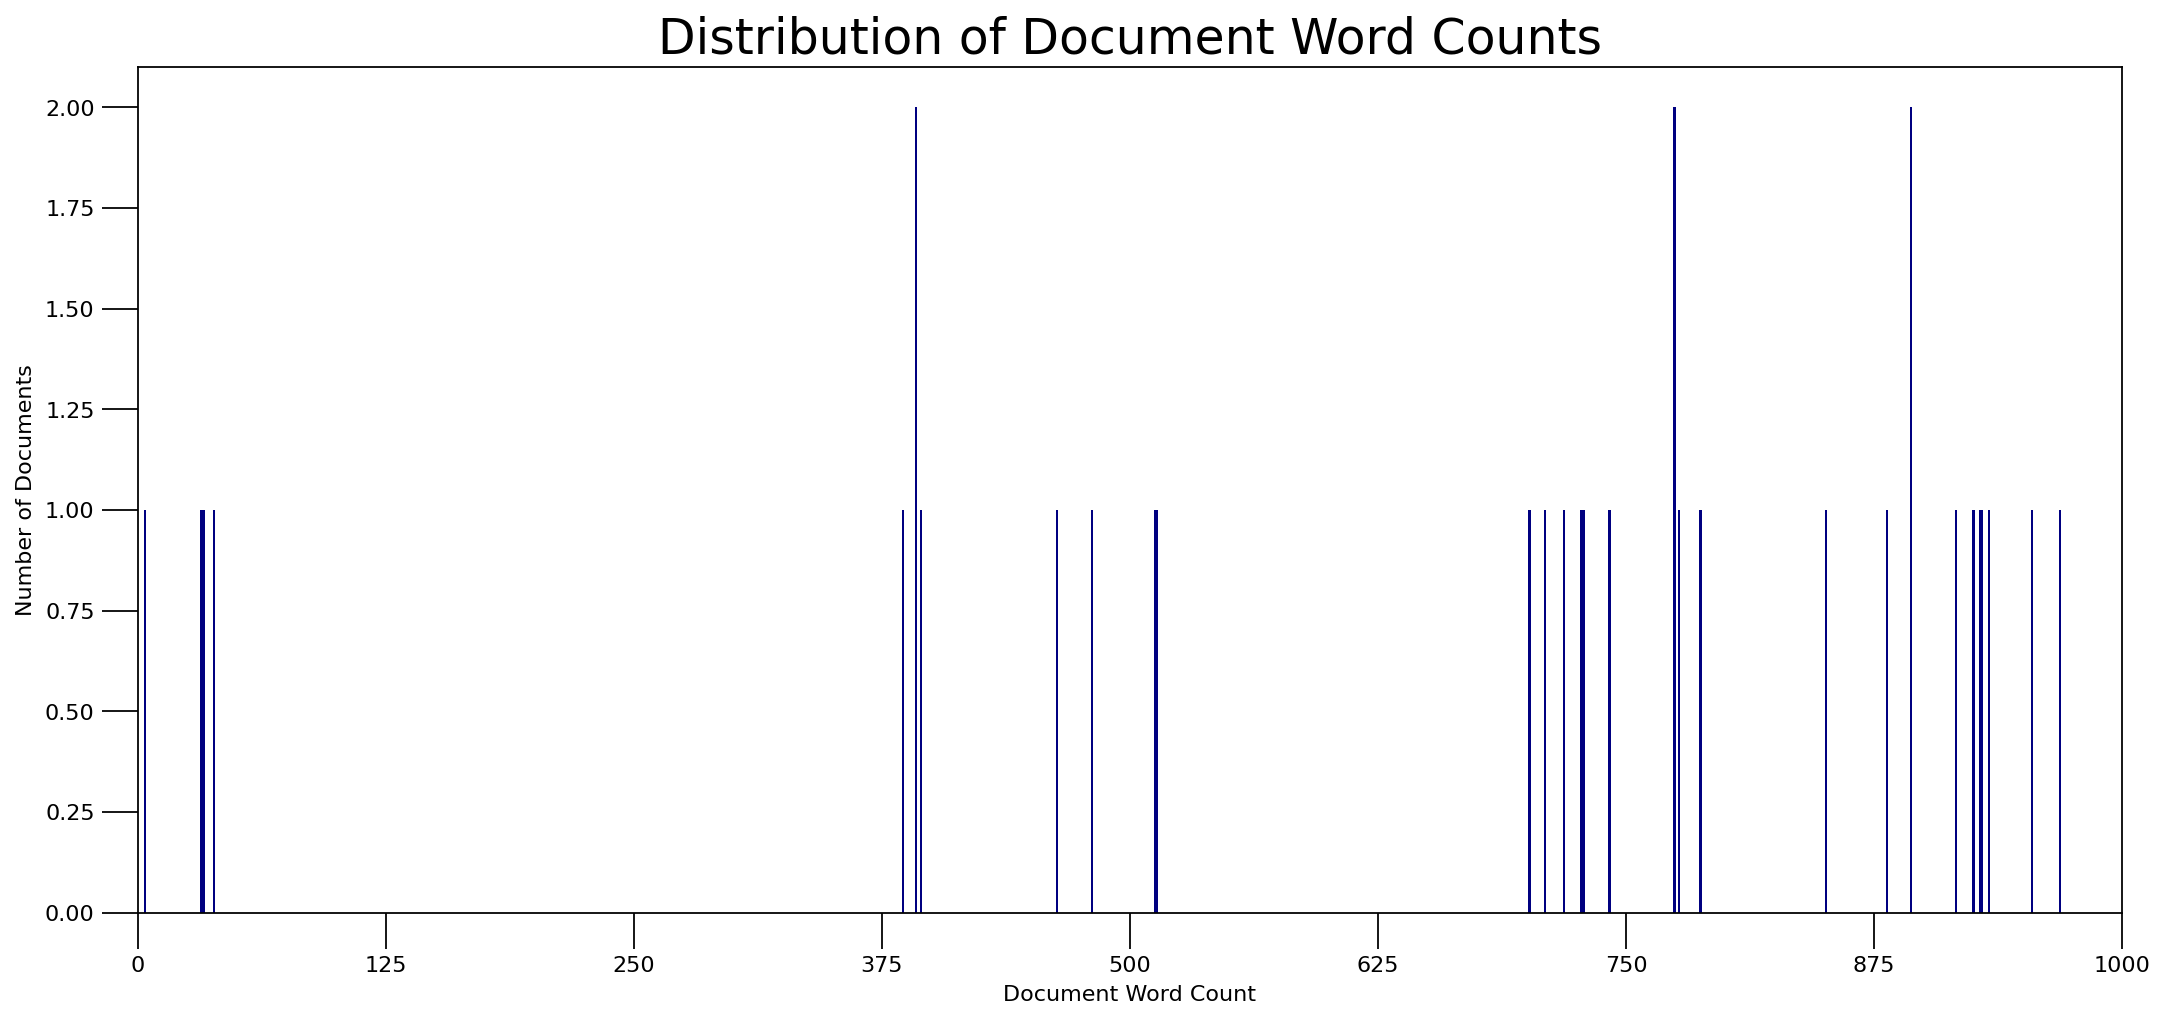

In [65]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


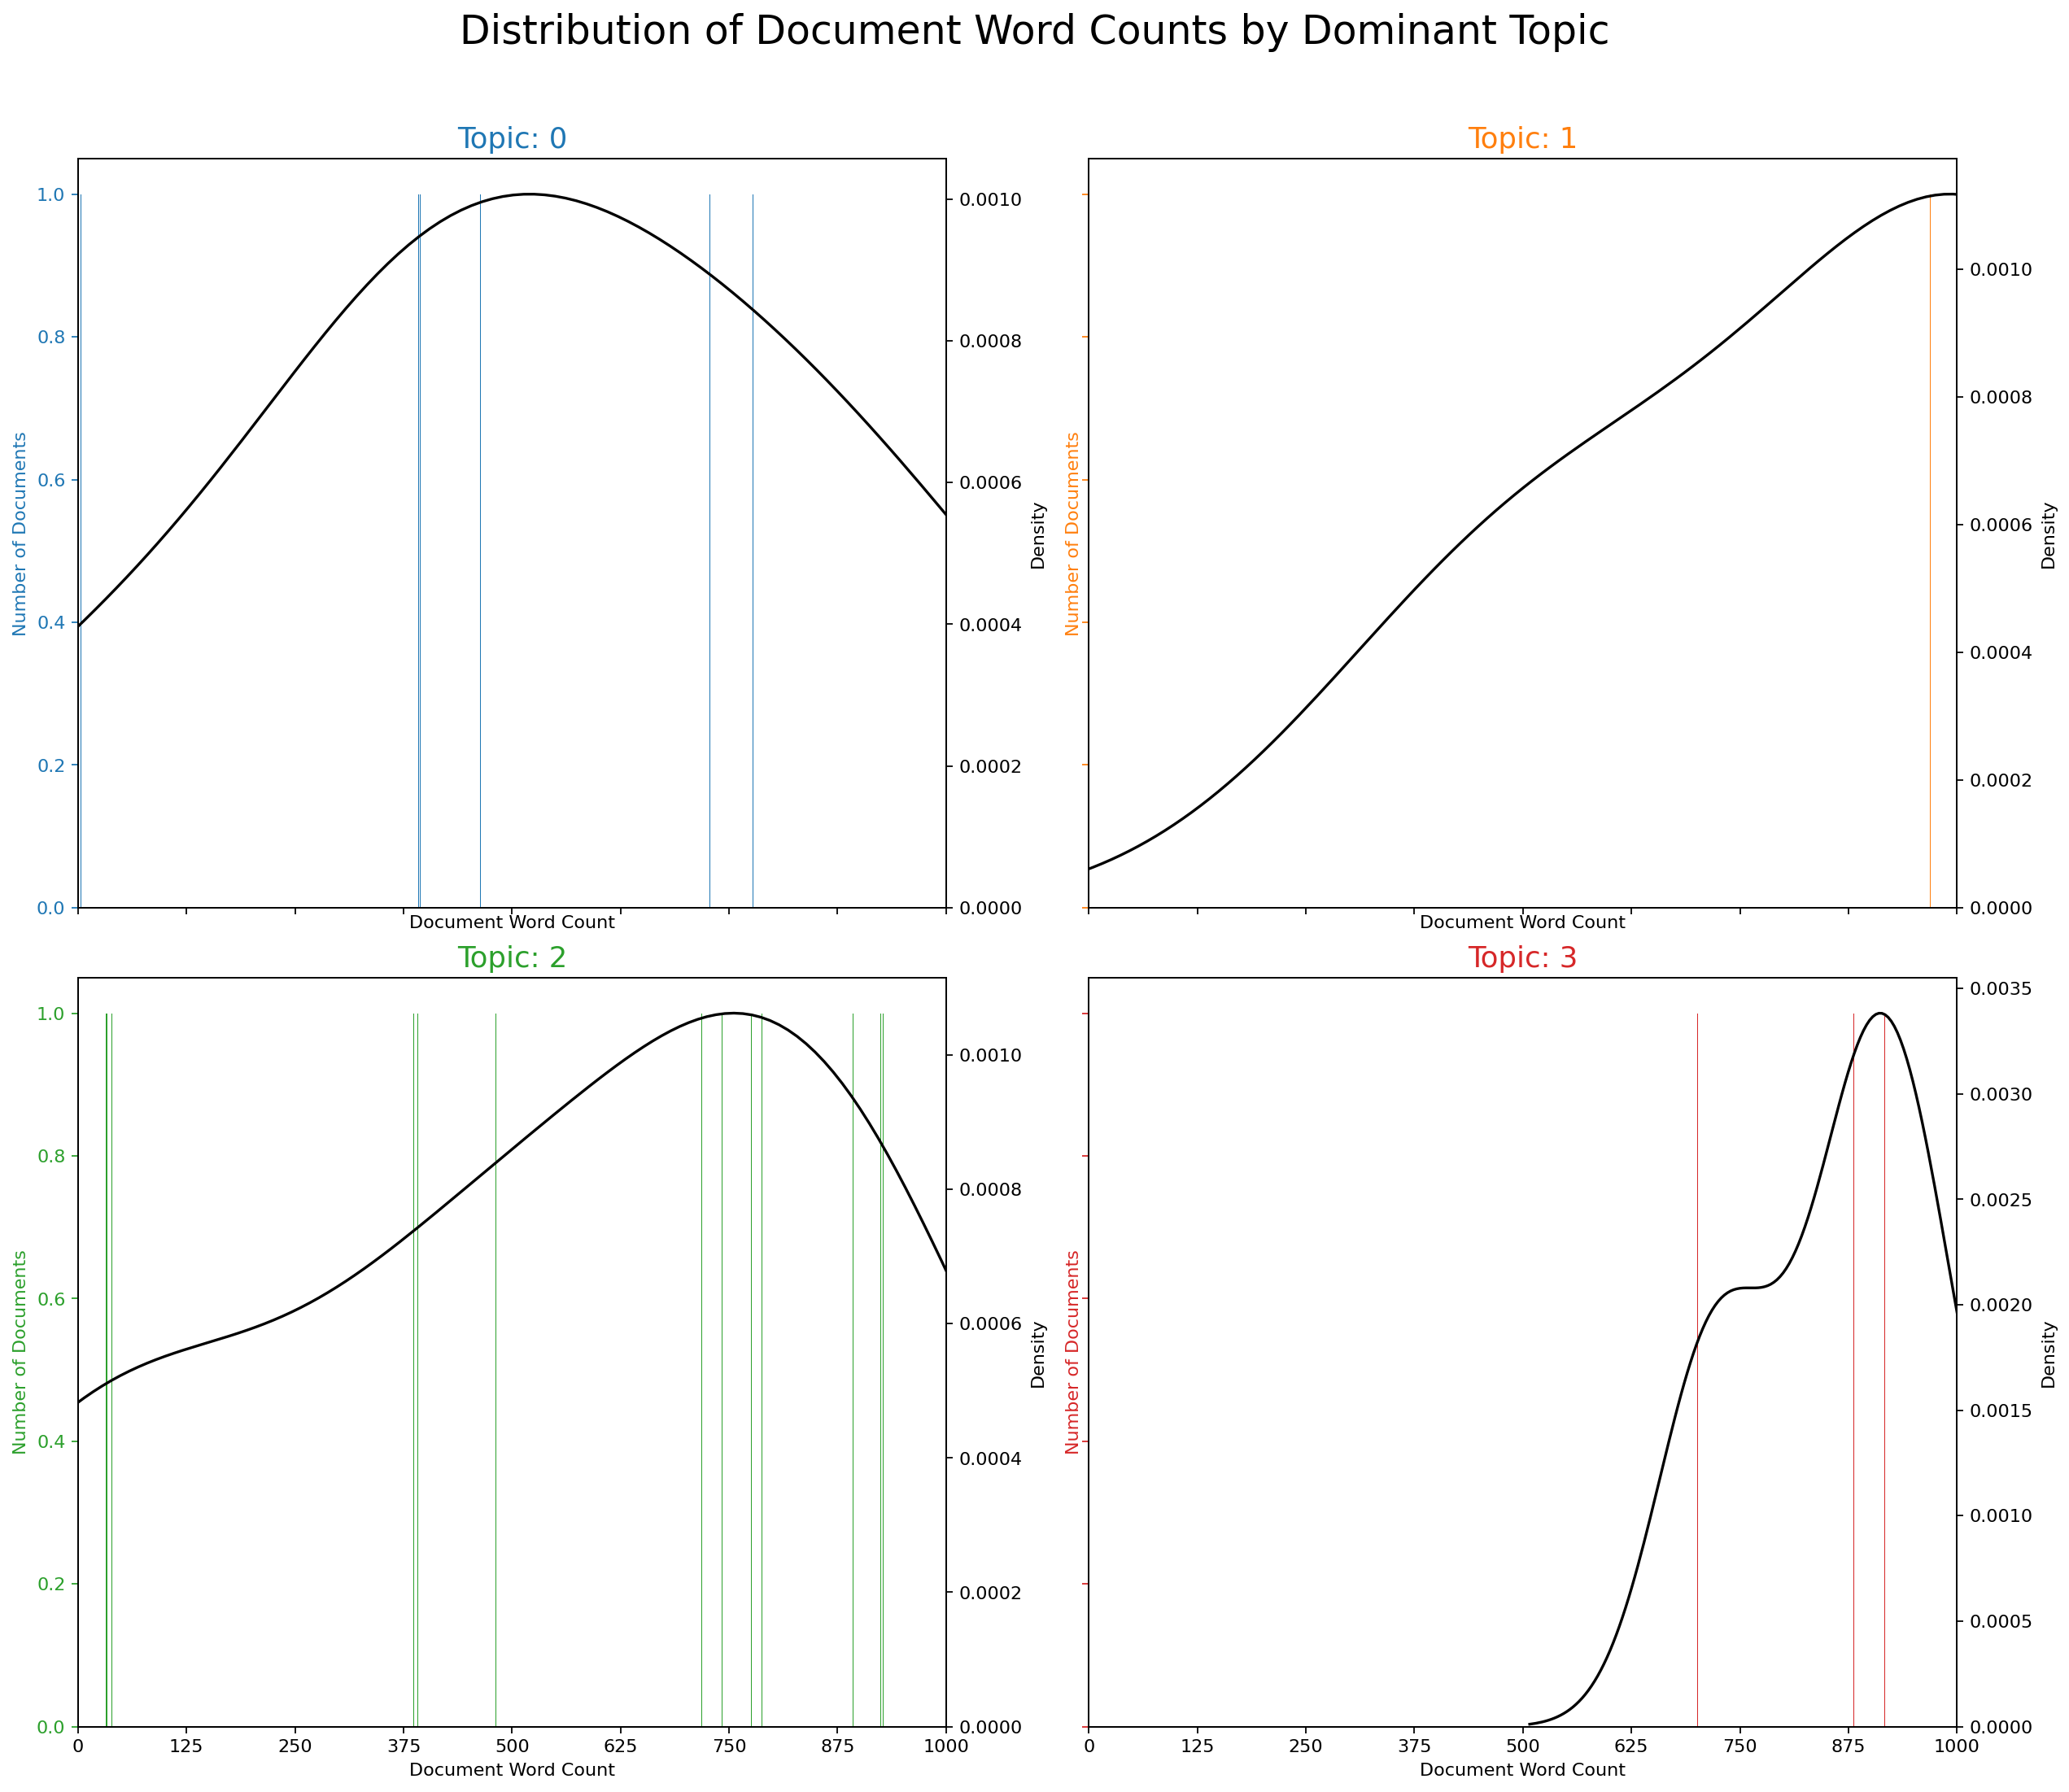

In [66]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


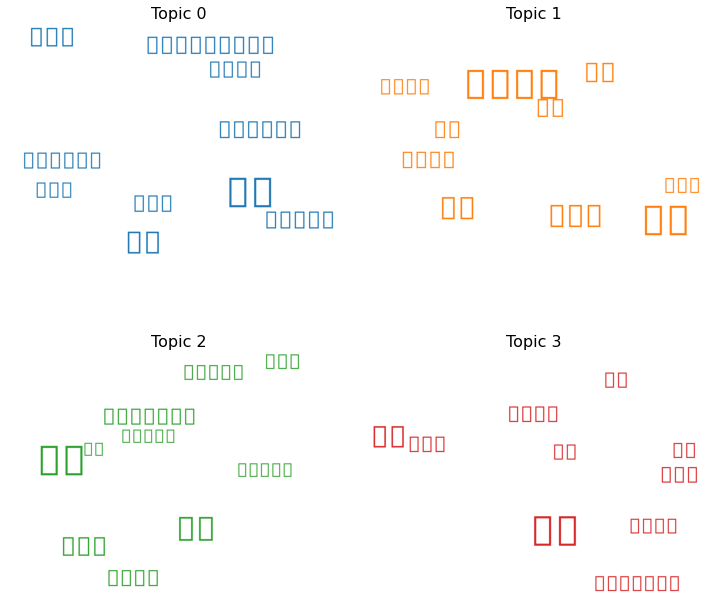

In [67]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-68-3105a4a9aef8>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-68-3105a4a9aef8>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-68-3105a4a9aef8>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-

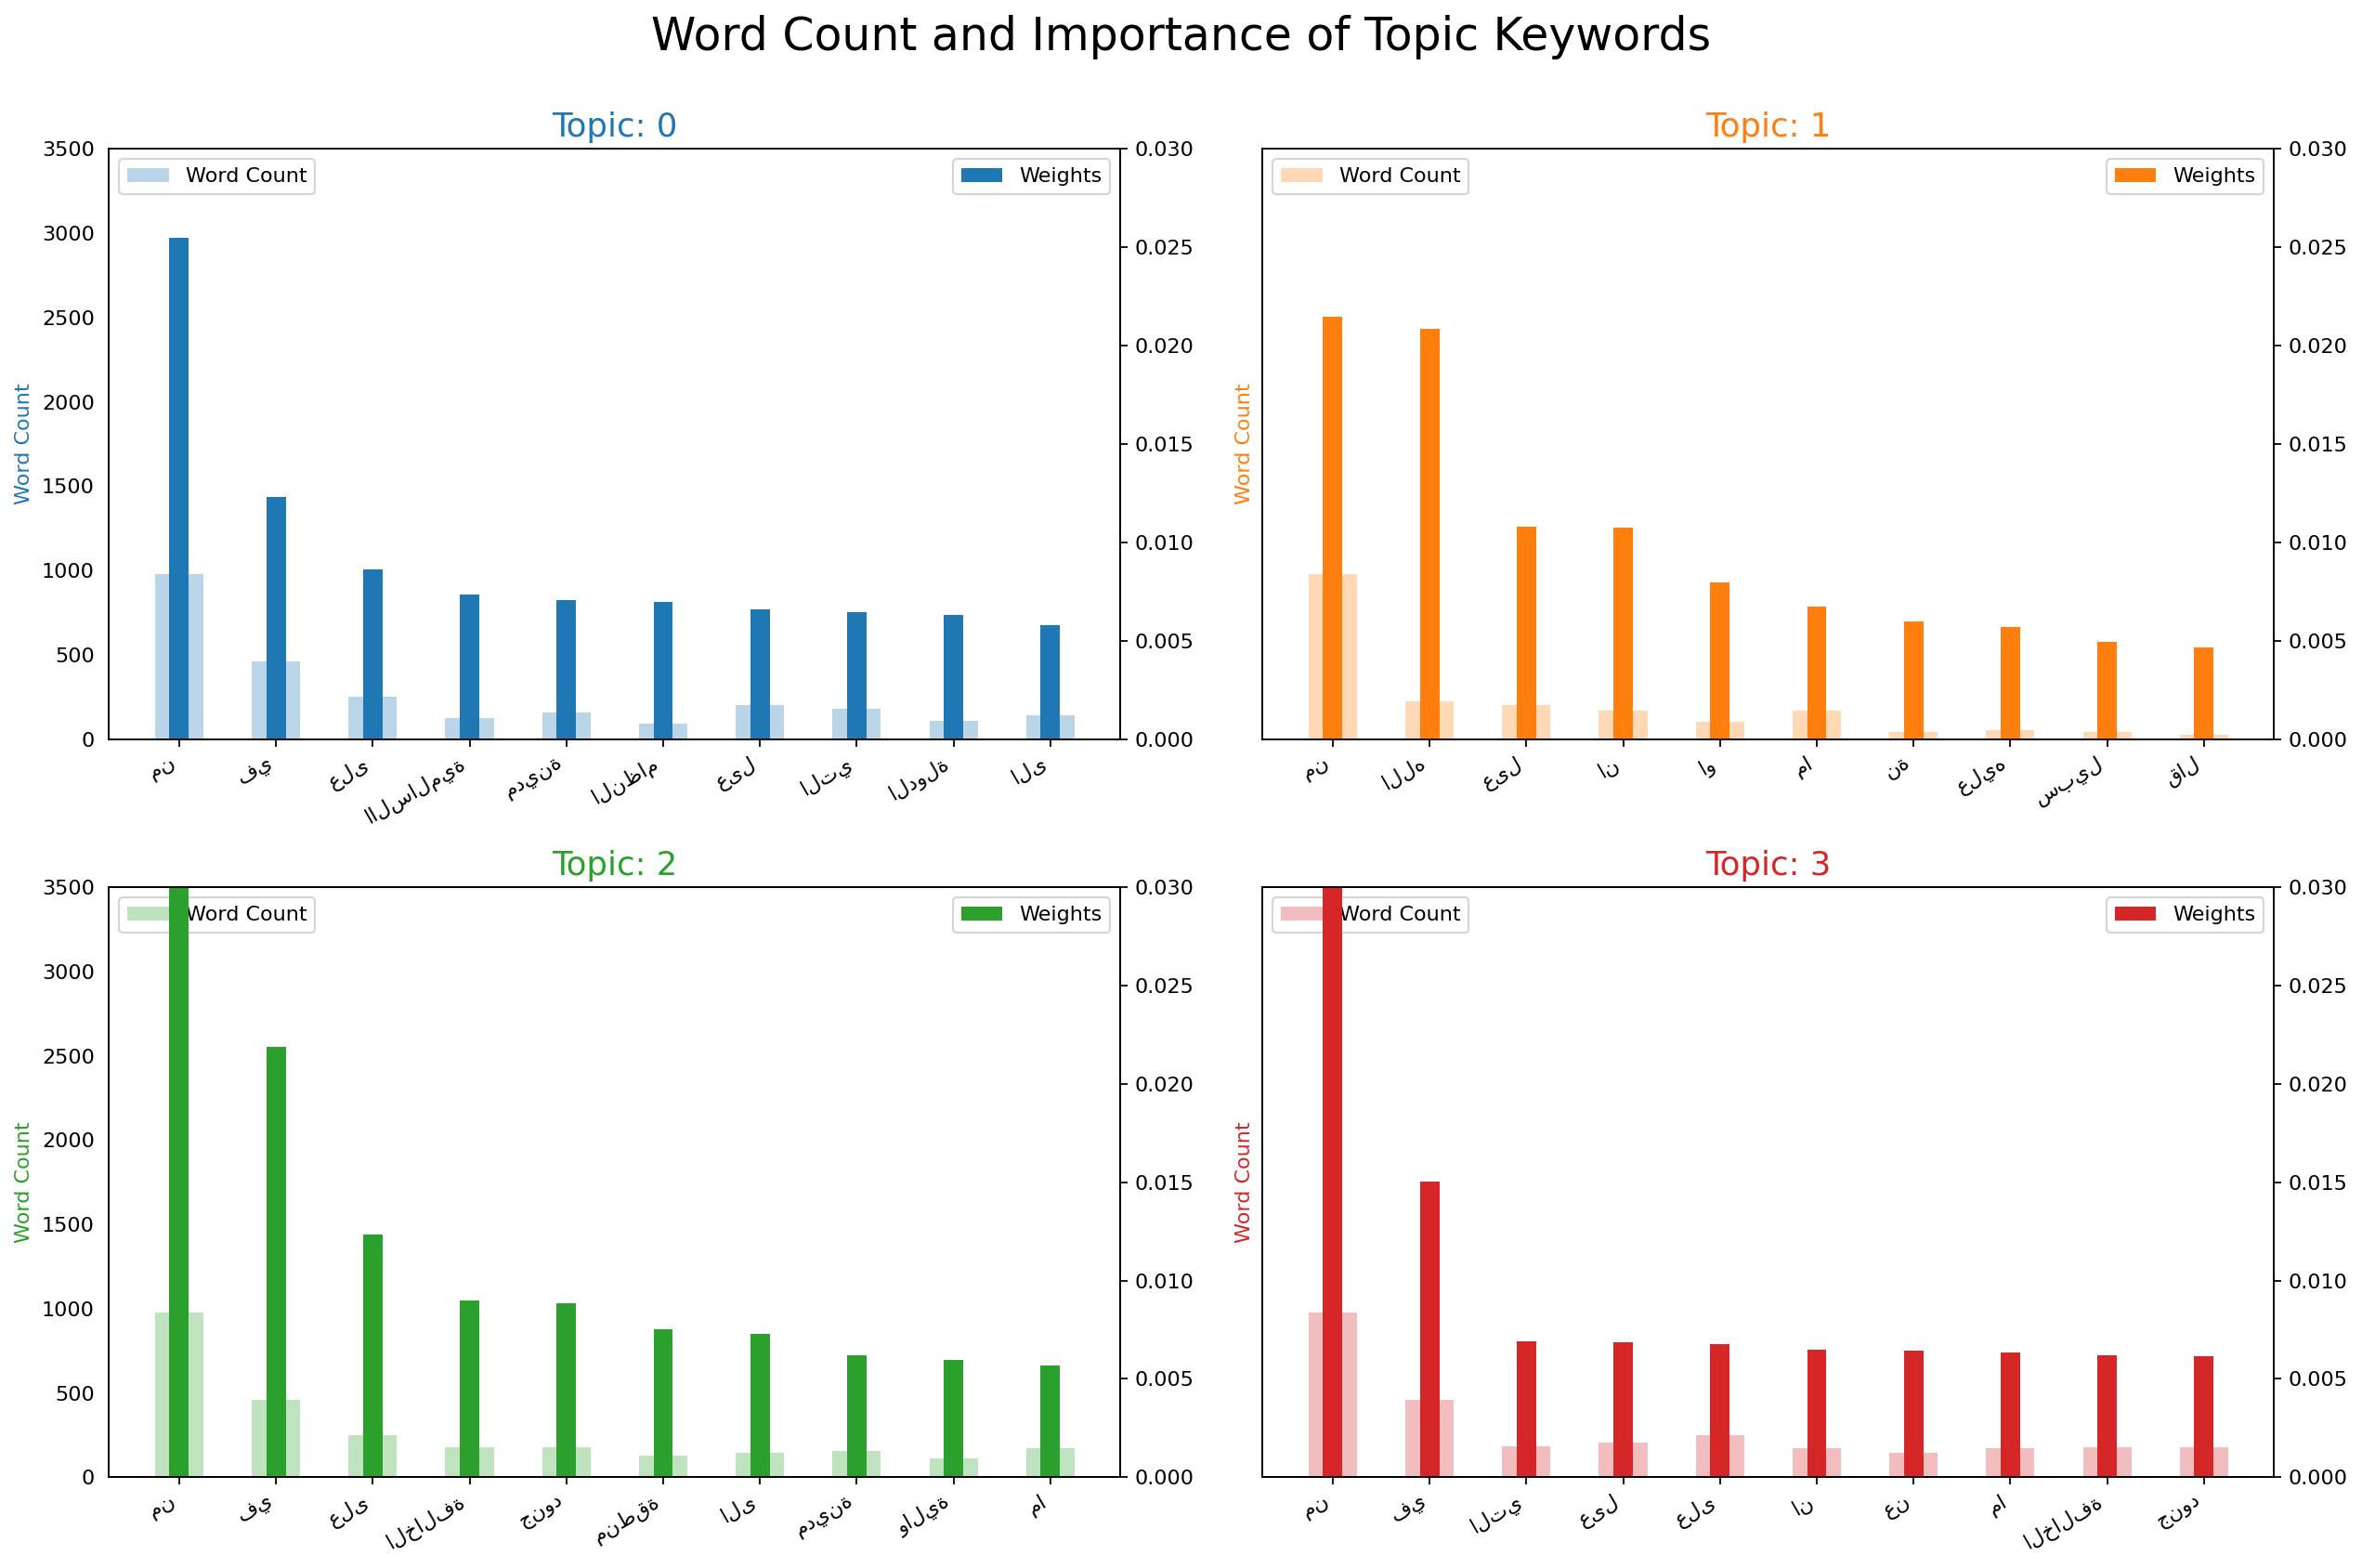

In [68]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


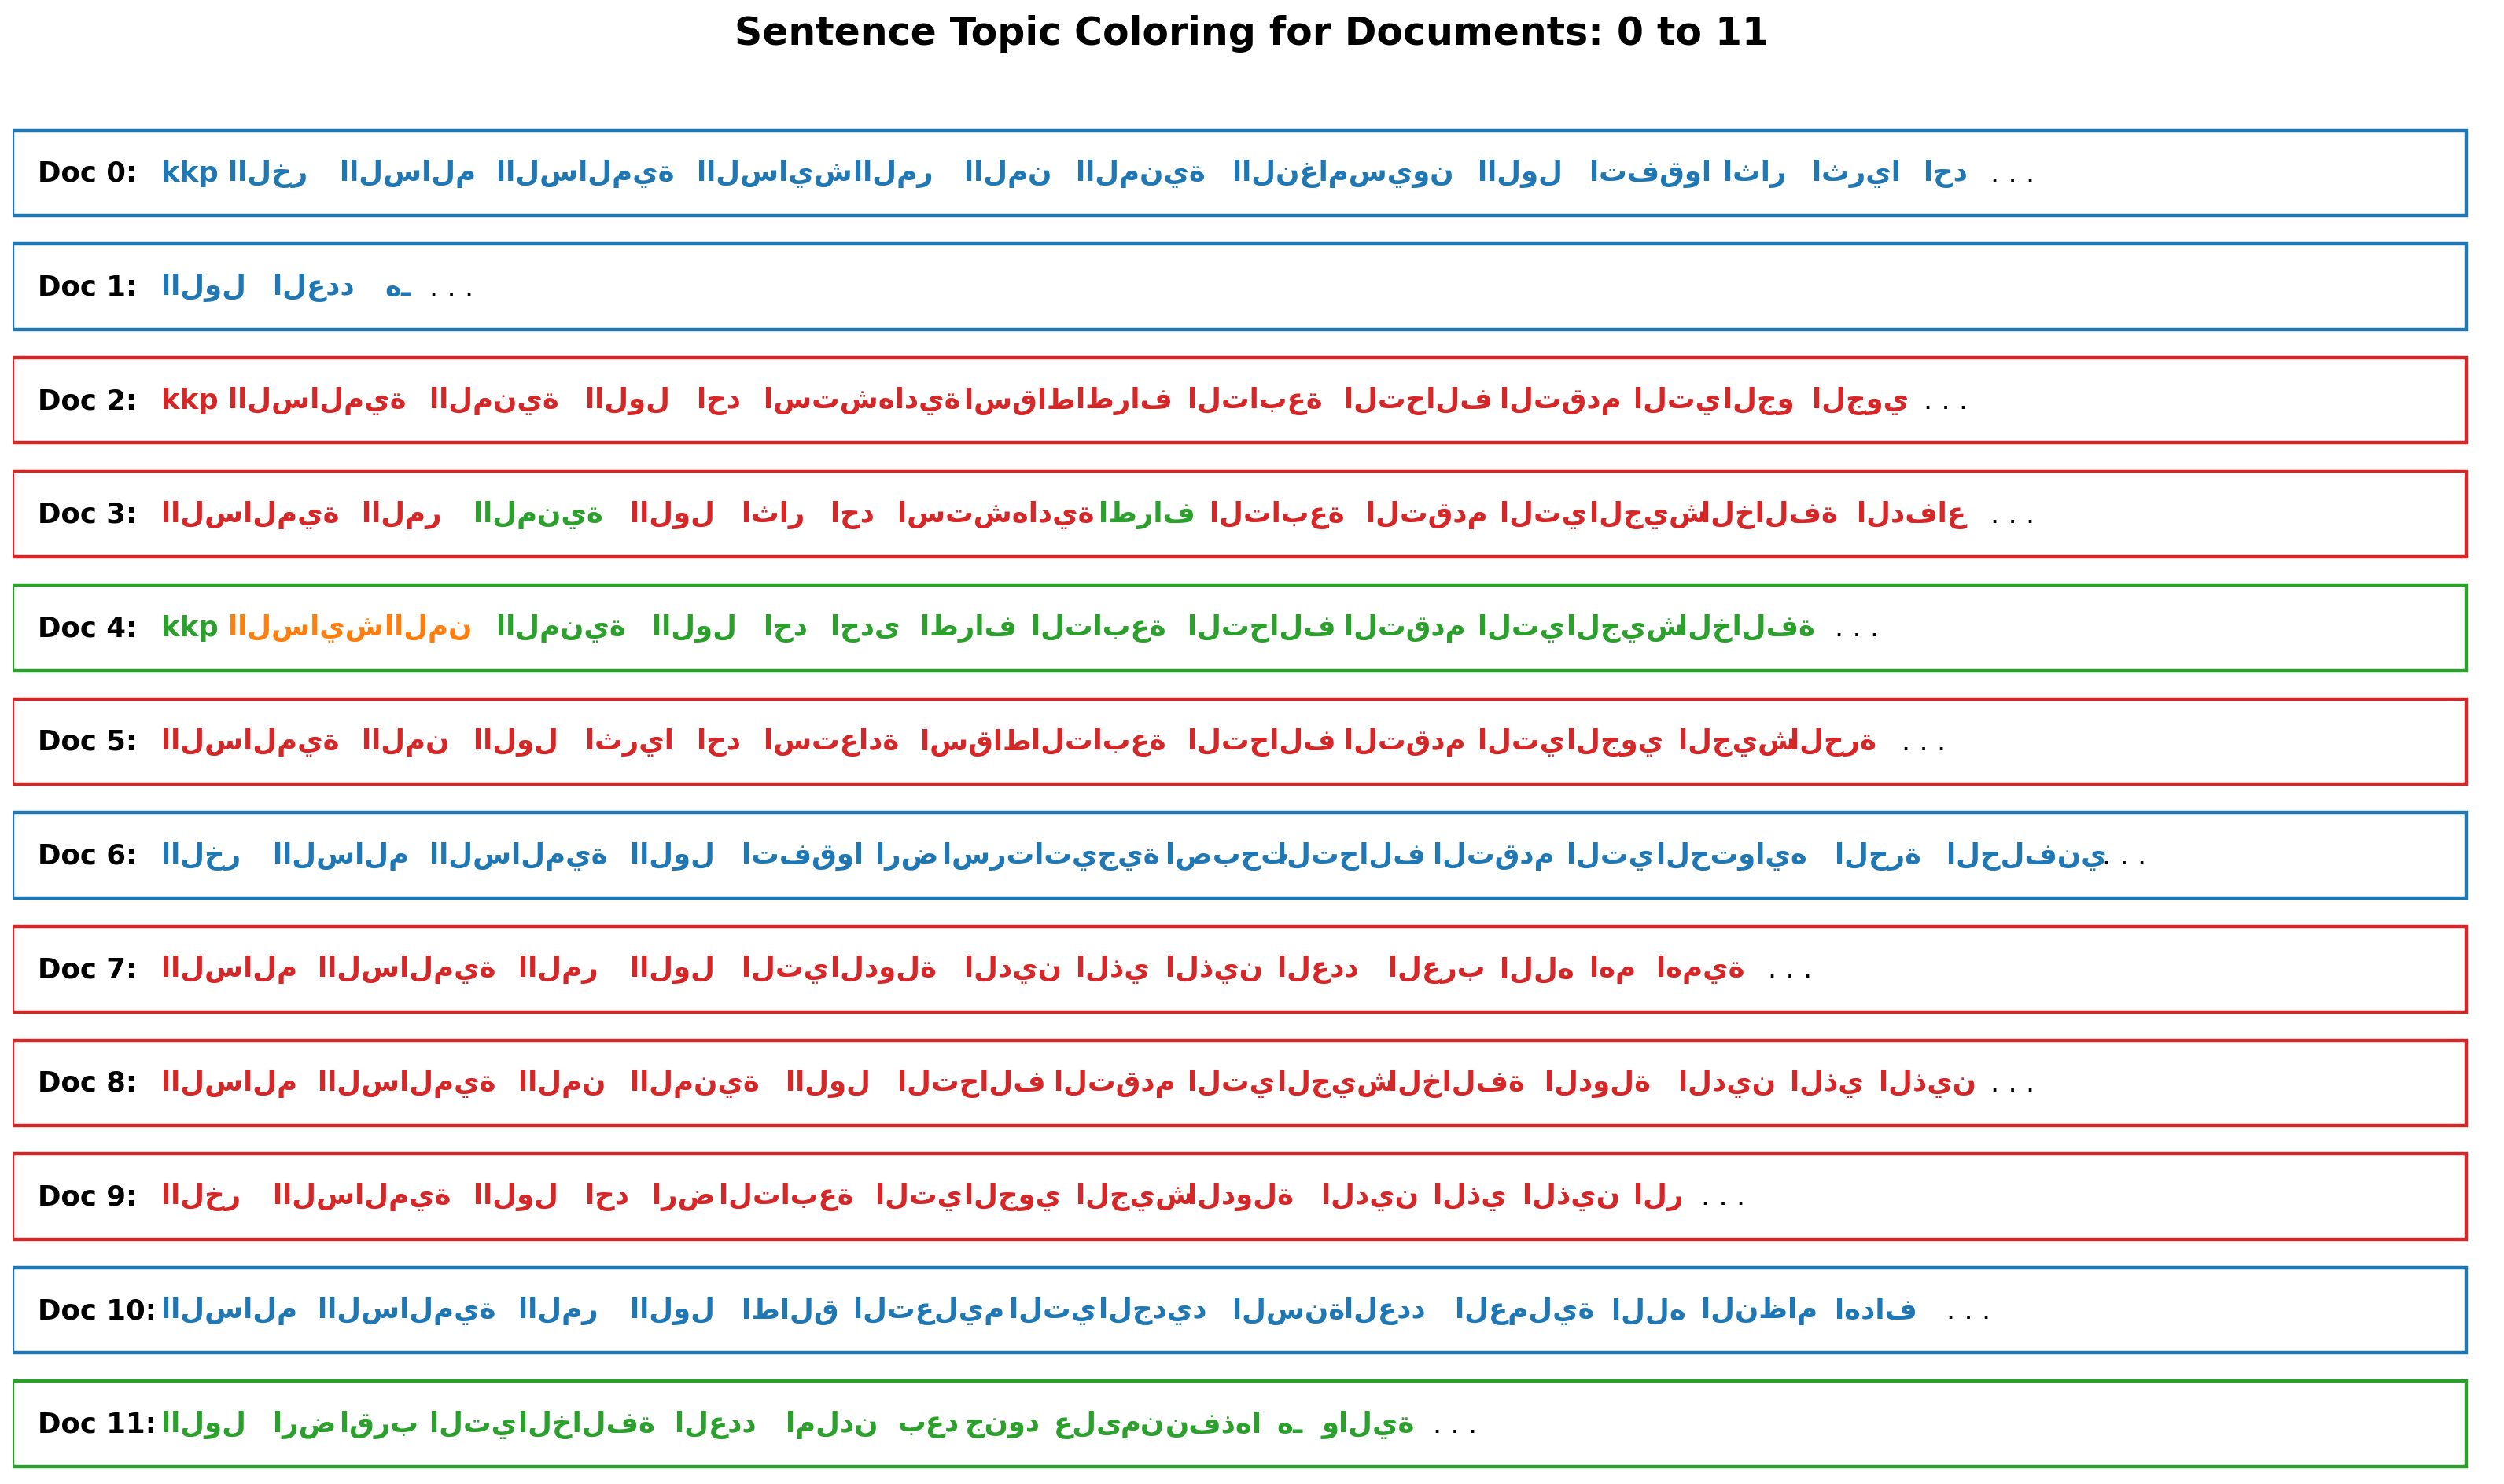

In [69]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()   

In [70]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


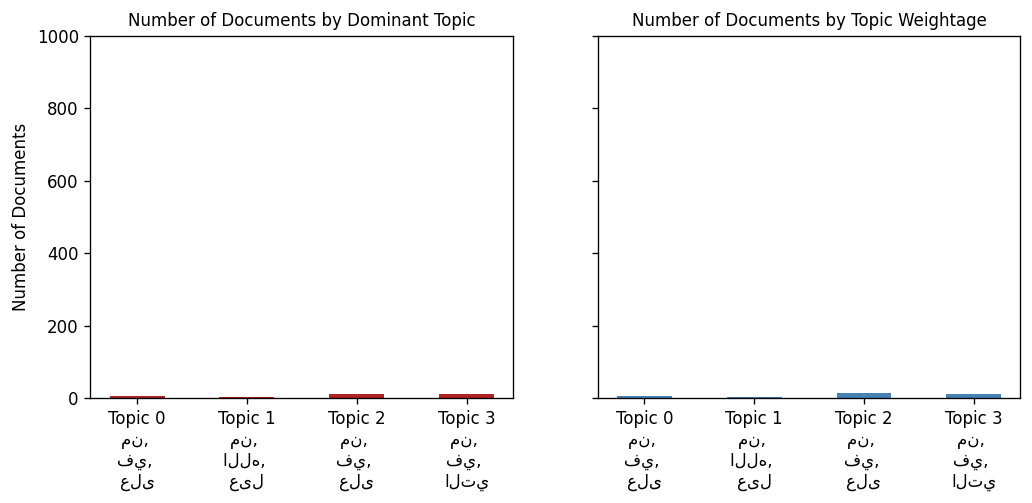

In [71]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [72]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[t-SNE] Computing 35 nearest neighbors...
[t-SNE] Indexed 36 samples in 0.000s...
[t-SNE] Computed neighbors for 36 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 36 / 36
[t-SNE] Mean sigma: 0.378101
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.217903
[t-SNE] KL divergence after 1000 iterations: 0.456846


Loading BokehJS ...